In [ ]:
import cv2
import torch
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from PIL import Image
import tifffile
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
image_path="/content/drive/MyDrive/ACV/Assignment-1/TEST_IMAGES/house.tif"

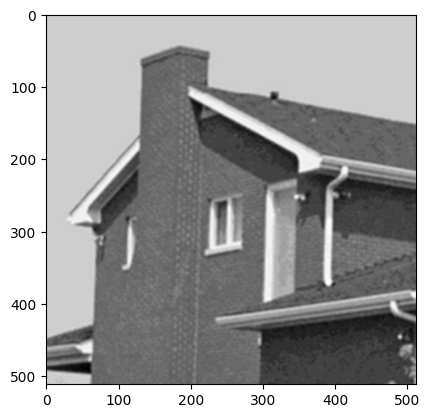

In [ ]:
# Reading the image in grayscale
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Converting the image to PyTorch tensor
image_tensor = torch.tensor(image)

plt.imshow(image_tensor.numpy(), cmap='gray')
plt.show()

In [ ]:
#Creating a 2D Gaussian kernel based on the provided sigma and width parameters.
#Convering it to PyTorch tensor and convolve the input image with LoG filter.

def laplacian_of_gaussian(image, sigma, width):

    x, y = np.meshgrid(np.arange(-width//2+1, width//2+1), np.arange(-width//2+1, width//2+1))
    kernel = -(1/(np.pi * sigma**4)) * (1 - ((x**2 + y**2) / (2 * sigma**2))) * np.exp(-(x**2 + y**2) / (2 * sigma**2))
    log_filter = torch.from_numpy(kernel / np.sum(np.abs(kernel)))

    n_image = F.conv2d(image.unsqueeze(0).unsqueeze(0).float(), log_filter.unsqueeze(0).unsqueeze(0).float())

    return n_image.squeeze(0).squeeze(0)

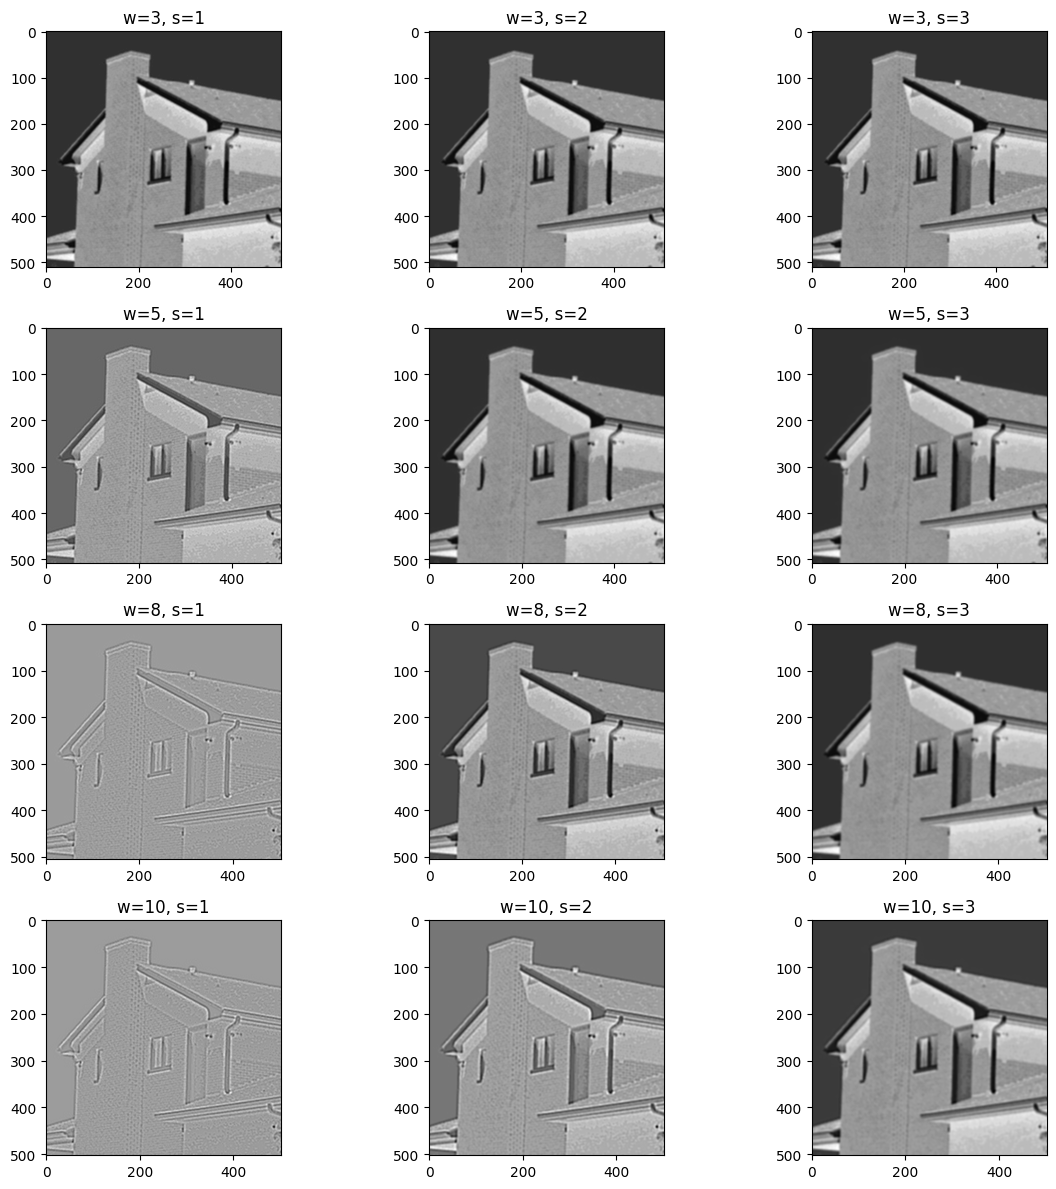

In [ ]:
width = [3, 5, 8, 10]
sigma = [1, 2, 3]

fig, axs = plt.subplots(len(width), len(sigma), figsize=(12, 12))

for x, w in enumerate(width):
    for y, s in enumerate(sigma):
        edges = laplacian_of_gaussian(image_tensor, sigma=s, width=w)
        axs[x, y].imshow(edges.numpy(), cmap='gray')
        axs[x, y].set_title(f'w={w}, s={s}')

plt.tight_layout()
plt.show()

In [ ]:
from sklearn import linear_model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
def initialize_accumulator(edge_tensor):
    theta_values = torch.linspace(-90.0, 90.0, 180)
    diagonal_length = int(round((edge_tensor.size(0) ** 2 + edge_tensor.size(1) ** 2) ** 0.5))
    rho_values = torch.linspace(-diagonal_length, diagonal_length, int(diagonal_length * 2))
    accumulator = torch.zeros((len(rho_values), len(theta_values)))
    return accumulator, theta_values, rho_values

In [ ]:
def get_edge_indices(edge_tensor):
    return edge_tensor.nonzero(as_tuple=True)

In [ ]:
def perform_hough_transform(edge_indices_x, edge_indices_y, accumulator, theta_values, diagonal_length):
    for i in range(len(edge_indices_x)):
        x_coordinate = edge_indices_x[i]
        y_coordinate = edge_indices_y[i]

        for j in range(len(theta_values)):
            rho_value = diagonal_length + int(torch.round(x_coordinate * torch.cos(theta_values[j]) + y_coordinate * torch.sin(theta_values[j])))
            accumulator[rho_value, j] += 1
    return accumulator

In [ ]:
def hough_transform(edge_tensor):
    accumulator, theta_values, rho_values = initialize_accumulator(edge_tensor)
    edge_indices_y, edge_indices_x = get_edge_indices(edge_tensor)
    accumulator = perform_hough_transform(edge_indices_x, edge_indices_y, accumulator, theta_values, len(rho_values) // 2)
    return accumulator, theta_values, rho_values

In [ ]:
accumulator, theta, rho = hough_transform(edges)

In [ ]:
# Use RANSAC to compute the parameters of the lines
model = linear_model.RANSACRegressor()
x_idxs, y_idxs = torch.nonzero(accumulator, as_tuple=True)
model.fit(x_idxs.unsqueeze(1), y_idxs)

RANSACRegressor()

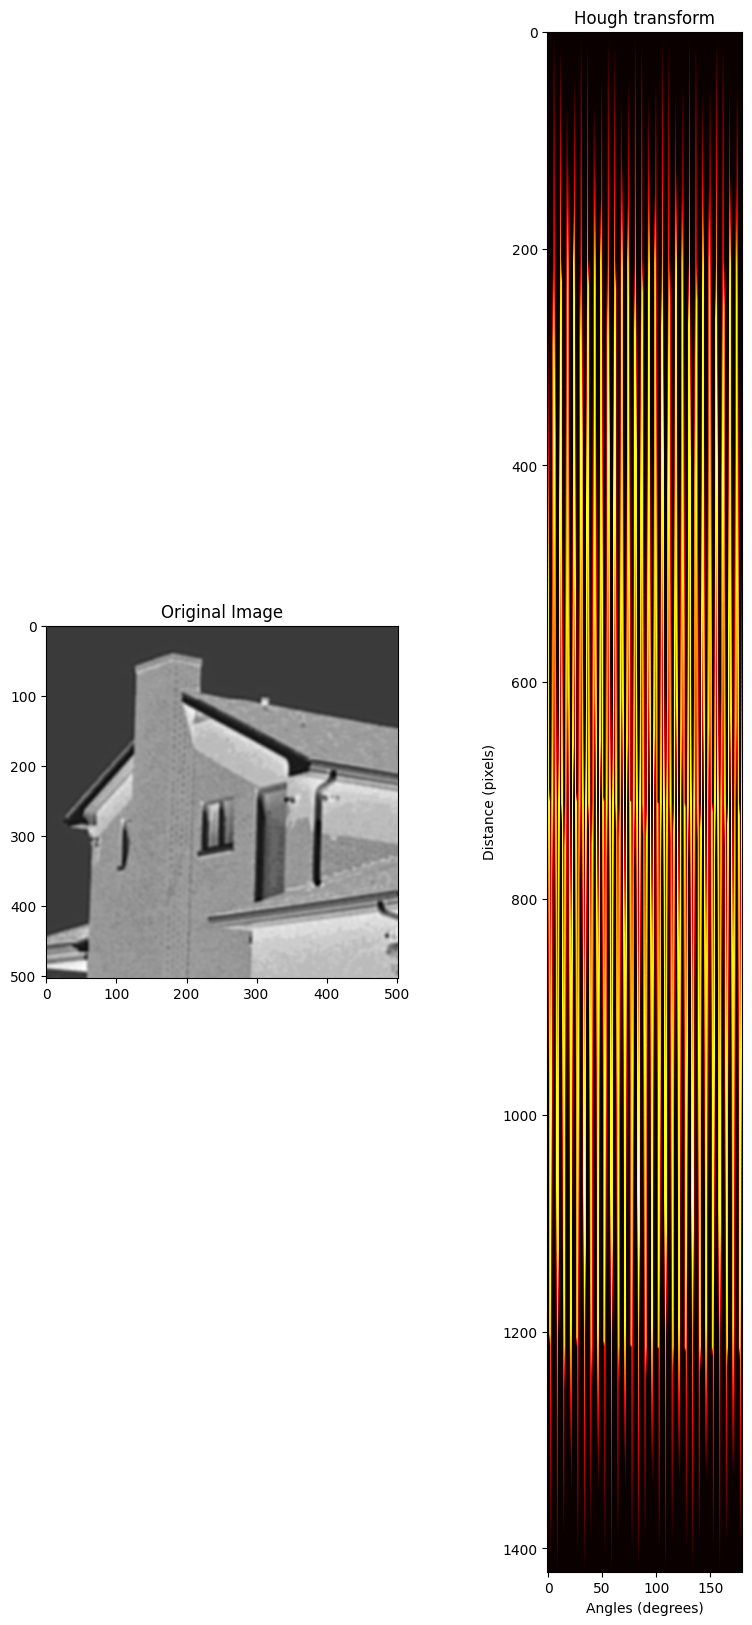

In [ ]:
# Plot the lines alongside the original image
fig, ax = plt.subplots(1, 2, figsize=(10, 20))

ax[0].imshow(edges, cmap='gray')
ax[0].set_title('Original Image')

ax[1].imshow(accumulator, cmap='hot')
ax[1].set_title('Hough transform')
ax[1].set_xlabel('Angles (degrees)')
ax[1].set_ylabel('Distance (pixels)')
ax[1].axis('image')

plt.show()